# Document Clustering and Topic Modeling

In this project, we use unsupervised learning models to cluster unlabeled documents into different groups, visualize the results and identify their latent topics/structures.

## Contents

<ul>
<li>[Part 1: Load Data](#Part-1:-Load-Data)
<li>[Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
<li>[Part 3: TF-IDF](#Part-3:-TF-IDF)
<li>[Part 4: K-means clustering](#Part-4:-K-means-clustering)
<li>[Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)
</ul>

# Part 1: Load Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
import re
import os

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

Read data from files. In summary, we have 100 titles and 100 synoposes (combined from imdb and wiki).

In [2]:
#import three lists: titles and wikipedia synopses
titles = open('./title_list.txt').read().split('\n')
titles = titles[:100] #ensures that only the first 100 are read in

#The wiki synopses and imdb synopses of each movie is seperated by the keywords "BREAKS HERE". 
#Each synoposes may consist of multiple paragraphs.
synopses_wiki = open('./synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_imdb = open('./synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

#Combine imdb and wiki to get full synoposes for the top 100 movies. 
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
    
#Because these synopses have already been ordered in popularity order, 
#we just need to generate a list of ordered numbers for future usage.
ranks = range(len(titles))

# Part 2: Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library.
Stop words are words like "a", "the", or "in" which don't convey significant meaning.
Stemming is the process of breaking a word down into its root.

In [3]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

print("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print(stopwords[:20])

We use 179 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [4]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
#     tokens=[]
#     for sent in nltk.sent_tokenize(text):
#         for word in nltk.word_tokenize(sent):
#             if word not in stopwords:
#                 tokens.append(word);   
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [5]:
tokenization_and_stemming("she looked at her father's arm.")

['look', 'father', "'s", 'arm']

Use our defined functions to analyze (i.e. tokenize, stem) our synoposes.

In [6]:
docs_stemmed = []
docs_tokenized = []
for i in synopses:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    
    tokenized_results = tokenization(i)
    docs_tokenized.extend(tokenized_results)

Create a mapping from stemmed words to original tokenized words for result interpretation.

In [7]:
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}
# print(vocab_frame_dict)
# print(vocab_frame_dict['angel'])  ## some misstemming

# Part 3: TF-IDF

In [8]:
#define vectorizer parameters
tfidf_model = TfidfVectorizer(max_df=0.8, max_features=2000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(synopses) #fit the vectorizer to synopses

## print(tfidf_matrix)
# get (document_id, token_id), and tf-idf score of a given token in a given document.

print(tfidf_model.get_feature_names()[:30])
print("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " synoposes and " + str(tfidf_matrix.shape[1]) + " terms.")

["'d", 'abandon', 'abl', 'accept', 'accid', 'accompani', 'accus', 'act', 'action', 'actual', 'admit', 'afterward', 'ago', 'agre', 'air', 'aliv', 'allow', 'alon', 'alreadi', 'alway', 'american', 'angri', 'angrili', 'announc', 'anoth', 'answer', 'anyon', 'anyth', 'apart', 'appar']
In total, there are 100 synoposes and 538 terms.


In [9]:
tfidf_model.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 2000,
 'min_df': 0.2,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming(text)>,
 'use_idf': True,
 'vocabulary': None}

Save the terms identified by TF-IDF.

In [10]:
tf_selected_words = tfidf_model.get_feature_names()

In [11]:
tfidf_matrix

<100x538 sparse matrix of type '<class 'numpy.float64'>'
	with 19003 stored elements in Compressed Sparse Row format>

In [12]:
#tf_selected_words

### Calculate Document Similarity

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(tfidf_matrix)
print(cos_matrix)
# print(cos_matrix.shape) # 100 documents (100*100)

[[1.         0.1996283  0.23342595 ... 0.3581728  0.3277855  0.17714484]
 [0.1996283  1.         0.26626879 ... 0.26910321 0.22856581 0.10870124]
 [0.23342595 0.26626879 1.         ... 0.27738654 0.24669308 0.12805055]
 ...
 [0.3581728  0.26910321 0.27738654 ... 1.         0.55040973 0.08151334]
 [0.3277855  0.22856581 0.24669308 ... 0.55040973 1.         0.13005234]
 [0.17714484 0.10870124 0.12805055 ... 0.08151334 0.13005234 1.        ]]


# Part 4: K-means clustering

In [14]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()
print(clusters)

[2, 4, 0, 3, 4, 4, 2, 3, 0, 3, 4, 2, 1, 3, 1, 2, 2, 2, 1, 4, 0, 3, 2, 2, 4, 3, 3, 1, 0, 4, 2, 4, 0, 2, 2, 4, 4, 0, 4, 0, 2, 2, 0, 3, 3, 0, 2, 2, 4, 0, 2, 1, 0, 2, 1, 4, 0, 4, 2, 2, 2, 4, 4, 1, 0, 3, 2, 3, 1, 0, 2, 3, 3, 3, 2, 3, 1, 2, 2, 1, 0, 3, 3, 3, 3, 1, 1, 0, 4, 4, 1, 0, 1, 0, 1, 2, 1, 1, 1, 3]


## 4.1. Analyze K-means Result

In [15]:
# create DataFrame films from all of the input files.
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters}
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster'])

In [16]:
frame.head(10)

,rank,title,cluster
2,0,The Godfather,2
4,1,The Shawshank Redemption,4
0,2,Schindler's List,0
3,3,Raging Bull,3
4,4,Casablanca,4
4,5,One Flew Over the Cuckoo's Nest,4
2,6,Gone with the Wind,2
3,7,Citizen Kane,3
0,8,The Wizard of Oz,0
3,9,Titanic,3


In [17]:
print("Number of films included in each cluster:")
frame['cluster'].value_counts().to_frame()

Number of films included in each cluster:


,cluster
2,26
3,20
4,18
0,18
1,18


In [18]:
grouped = frame['rank'].groupby(frame['cluster'])
print("Average rank (1 to 100) per cluster:")
grouped.mean().to_frame().sort_values(by=['rank'], ascending=False)

Average rank (1 to 100) per cluster:


,rank
cluster,
1,66.666667
3,52.150000
0,49.666667
2,43.115385
4,38.444444


In [19]:
print("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
print(order_centroids)
# -> get shape (5, 538)

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print("Cluster " + str(i) + " words:" ,)
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print(vocab_frame_dict[tf_selected_words[ind]] + ",",)
    print()
    #Here ix means index, which is the clusterID of each item.
    #cluster_movies = frame.ix[i]['title'].values.tolist() -> .ix[] is deprecated now.
    #Without tolist, the values result from dataframe is <type 'numpy.ndarray'>
    cluster_movies = frame.loc[i, 'title'].values.tolist()
    print("Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): ")
    print(", ".join(cluster_movies))
    print()

<Document clustering result by K-means>
[[241 493 320 ... 496 144   1]
 [ 83  28 359 ... 479 166 431]
 [192 194 271 ... 354 384 442]
 [213 201 298 ...  54 124  80]
 [452 106  35 ... 369 536  68]]
Cluster 0 words:
home,
town,
mr.,
killing,
water,
n't,

Cluster 0 titles (18 movies): 
Schindler's List, The Wizard of Oz, E.T. the Extra-Terrestrial, 12 Angry Men, Gandhi, Unforgiven, Rocky, To Kill a Mockingbird, My Fair Lady, Jaws, Butch Cassidy and the Sundance Kid, High Noon, City Lights, Mr. Smith Goes to Washington, The Green Mile, The African Queen, A Clockwork Orange, Wuthering Heights

Cluster 1 words:
car,
apartment,
police,
killing,
gun,
drives,

Cluster 1 titles (18 movies): 
Psycho, Vertigo, West Side Story, Some Like It Hot, The Good, the Bad and the Ugly, The Apartment, The French Connection, Midnight Cowboy, Fargo, Shane, American Graffiti, Pulp Fiction, The Maltese Falcon, Taxi Driver, Double Indemnity, Rear Window, The Third Man, North by Northwest

Cluster 2 words:
family,


## 4.2. Plot K-means Result

In [20]:
# PCA for plotting on R2 space purpose:
pca = decomposition.PCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:, 1]

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
#set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

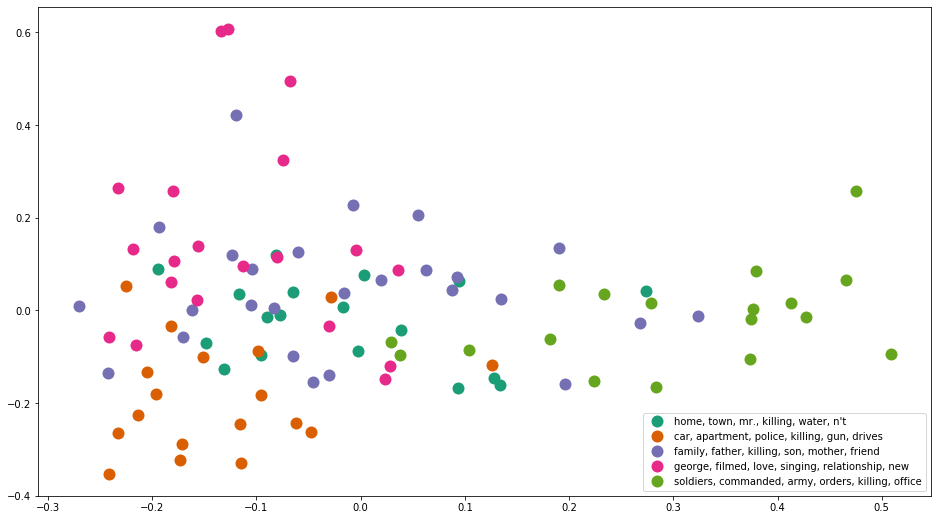

In [21]:
%matplotlib inline 

#create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
groups = df.groupby(clusters)

# set up plot
fig, ax = plt.subplots(figsize=(16, 9))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')

ax.legend(numpoints=1,loc=4)  #show legend with only 1 point, position is right bottom.

plt.show() #show the plot

In [22]:
plt.close()

# Part 5: Topic Modeling - Latent Dirichlet Allocation

In [23]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5, learning_method = 'online')

In [24]:
tfidf_matrix_lda = (tfidf_matrix * 100)
tfidf_matrix_lda = tfidf_matrix_lda.astype(int)

In [25]:
lda.fit(tfidf_matrix_lda)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [26]:
topic_word = lda.components_
print(topic_word.shape)

(5, 538)


In [27]:
n_top_words = 7
topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    #Here we select top(n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

In [28]:
doc_topic = lda.transform(tfidf_matrix_lda)
print(doc_topic.shape)

(100, 5)


In [29]:
topic_doc_dict = {}
print("<Document clustering result by LDA>")
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print("Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i]))
    print("Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): " )
    print(', '.join(topic_doc_dict[i]))
    print()

<Document clustering result by LDA>
Cluster 2 words: family, father, war, parents, marriages, marries
Cluster 2 titles (19 movies): 
The Godfather, Citizen Kane, Titanic, The Godfather: Part II, Chinatown, Amadeus, A Streetcar Named Desire, The Best Years of Our Lives, Ben-Hur, The Apartment, The King's Speech, Mr. Smith Goes to Washington, Rain Man, Good Will Hunting, Terms of Endearment, Giant, Network, Rebel Without a Cause, Yankee Doodle Dandy

Cluster 0 words: prison, captain, water, killing, train, car
Cluster 0 titles (19 movies): 
The Shawshank Redemption, One Flew Over the Cuckoo's Nest, Sunset Blvd., The Sound of Music, West Side Story, The Bridge on the River Kwai, My Fair Lady, The Good, the Bad and the Ugly, Butch Cassidy and the Sundance Kid, High Noon, Goodfellas, The French Connection, It Happened One Night, Midnight Cowboy, The African Queen, Mutiny on the Bounty, A Clockwork Orange, Wuthering Heights, Double Indemnity

Cluster 1 words: army, camping, killing, general,